## Imports

In [ ]:
import re
import os
import subprocess

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

## Utils

In [ ]:
def parse_performance_data(text):
    pattern = re.compile(
        r"Algorithm:\s*(?P<Algorithm>\S+)\s*"
        r"Instance:\s*(?P<Instance>\S+)\s*"
        r"Initial Score:\s*(?P<Initial_Score>\d+)\s*"
        r"Score:\s*(?P<Score>\d+)\s*"
        r"Number\s*of\s*Evaluations:\s*(?P<Number_of_Evaluations>\d+)\s*"
        r"Number\s*of\s*Performed\s*Moves:\s*(?P<Number_of_Performed_Moves>\d+)\s*"
        r"Number\s*of\s*Best\s*Solution\s*Updates:\s*(?P<Number_of_Best_Solution_Updates>\d+)\s*"
        r"Solution:\s*(?P<Solution>[\d\s]+)\s*"
        r"Optimal\s*Score:\s*(?P<Optimal_Score>\d+)\s*"
        r"Optimal\s*Solution:\s*(?P<Optimal_Solution>[\d\s]+)"
    )
    
    rows = []
    for match in pattern.finditer(text):
        row = match.groupdict()
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    numerical_cols = ['Initial_Score', 'Score', 'Number_of_Evaluations', 'Number_of_Performed_Moves', 'Number_of_Best_Solution_Updates', 'Optimal_Score']
    df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric)
    
    return df

def parse_runtime_data(text):
    pattern = re.compile(
        r"Algorithm:\s*(?P<Algorithm>\S+)\s*"
        r"Instance:\s*(?P<Instance>\S+)\s*"
        r"Runtime:\s*(?P<Runtime>\S+)\s*"
    )
    
    rows = []
    for match in pattern.finditer(text):
        row = match.groupdict()
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    numerical_cols = ['Runtime']
    df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric)
    
    return df


def run_bio_alg(instance_dir, runtime_results_file, performance_results_file, mode, instance_names, random_time=2871222):
    runtime_commands = [
        "bio_alg time heuristic 0 0 {dir} {instance} {result}",
        "bio_alg time random 0 0 {dir} {instance} {result}",
        "bio_alg time antiheuristic 0 0 {dir} {instance} {result}",
        "bio_alg time random 0 0 {dir} {instance} {result} greedyLS",
        "bio_alg time random 0 0 {dir} {instance} {result} steepestLS"
    ]

    performance_commands = [
        "bio_alg performance heuristic 100 0 {dir} {instance} {result}",
        "bio_alg performance antiheuristic 100 0 {dir} {instance} {result}",
        "bio_alg performance randomwalk 100 " + random_time + " {dir} {instance} {result}",
        "bio_alg performance randomsearch 100 " + random_time + " {dir} {instance} {result}",
        "bio_alg performance random 100 0 {dir} {instance} {result} greedyLS",
        "bio_alg performance random 100 0 {dir} {instance} {result} steepestLS"
    ]

    for instance in instance_names:
        assert os.path.exists(os.path.join(instance_dir, instance[:-4] + ".sln")), "Instance should have a corresponding .sln file"

    if os.path.exists(runtime_results_file):    
        os.remove(runtime_results_file)

    if os.path.exists(performance_results_file):    
        os.remove(performance_results_file)

    for instance in instance_names:
        if mode in ("runtime", "both"):
            for cmd in runtime_commands:
                for _ in range(10):  # Make 10 tests for standard deviation
                    formatted_cmd = cmd.format(dir=instance_dir, instance=instance, result=runtime_results_file)
                    subprocess.run(formatted_cmd, shell=True)

        if mode in ("performance", "both"):
            for cmd in performance_commands:
                formatted_cmd = cmd.format(dir=instance_dir, instance=instance, result=performance_results_file)
                subprocess.run(formatted_cmd, shell=True)


## Define variables
### Optional - run scripts from python

In [ ]:
# performance_file = 'results/performance_results.txt'
# runtime_file = 'results/runtime_results.txt'

performance_file = 'results/new_performance_results.txt'
runtime_file = 'results/new_runtime_results.txt'


In [ ]:
# Names of instances ordered by instance size
instance_names_ordered = ["wil100", "lipa80a", "lipa80b", "tai60a", "kra30a", "bur26a", "bur26b", "chr22a", "had14"]
instance_runtimes_greedy = [] #TODO

RANDOMRUNTIMES = {instance: runtime for instance, runtime in zip(instance_names_ordered, instance_runtimes_greedy)}

algorithm_colors = {
    "greedyLS": "#8dd3c7",
    "steepestLS": "#ffffb3",
    "heuristic": "#bebada",
    "antiheuristic": "#fb8072",
    "random": "#80b1d3",
    "randomwalk": "#fdb462",
    "randomsearch": "#b3de69"
}

In [ ]:
# run_bio_alg("data/qap/", "runtime_results.txt", "performance_results.txt", "both", instance_names_ordered, RANDOMRUNTIME)

## Read Data

In [ ]:
with open(performance_file, 'r') as file:
    data = file.read()

df_performance = parse_performance_data(data)
df_performance.Algorithm = df_performance.Algorithm.apply(lambda x: x[1:] if x.endswith("LS") else x)


In [ ]:
df_performance.tail()

,Algorithm,Instance,Initial_Score,Score,Number_of_Evaluations,Number_of_Performed_Moves,Number_of_Best_Solution_Updates,Solution,Optimal_Score,Optimal_Solution
5395,steepestLS,chr15a,71904,17754,1260,11,11,14 2 0 11 9 3 5 13 1 10 4 6 8 7 12 \t,9896,5 10 8 13 12 11 14 2 4 6 7 15 3 1 9 \n
5396,steepestLS,chr15a,51464,13914,1155,10,10,12 1 4 6 7 13 2 0 8 5 3 10 9 14 11 \t,9896,5 10 8 13 12 11 14 2 4 6 7 15 3 1 9 \n
5397,steepestLS,chr15a,72126,13602,1155,10,10,8 12 2 0 4 9 11 13 14 5 7 3 1 10 6 \t,9896,5 10 8 13 12 11 14 2 4 6 7 15 3 1 9 \n
5398,steepestLS,chr15a,66776,12970,1260,11,11,2 4 8 11 12 10 9 14 7 5 3 13 1 0 6 \t,9896,5 10 8 13 12 11 14 2 4 6 7 15 3 1 9 \n
5399,steepestLS,chr15a,68118,14816,1155,10,10,12 3 4 8 14 7 2 13 9 10 0 11 1 5 6 \t,9896,5 10 8 13 12 11 14 2 4 6 7 15 3 1 9 \n


In [ ]:
with open(runtime_file, 'r') as file:
    data = file.read()

df_runtime = parse_runtime_data(data)

In [ ]:
df_runtime.head()

,Algorithm,Instance,Runtime
0,heuristic,wil100,78967.0
1,heuristic,wil100,63359.0
2,heuristic,wil100,41195.0
3,heuristic,wil100,47166.0
4,heuristic,wil100,44185.0


In [211]:
df_runtime[df_runtime.Algorithm == "greedyLS"].groupby(["Algorithm", "Instance"])["Runtime"].agg(["mean", "std"]).reset_index()

,Algorithm,Instance,mean,std
0,greedyLS,bur26a,3.607529e+06,2.906093e+05
1,greedyLS,bur26b,3.326566e+06,3.062413e+05
2,greedyLS,chr15a,2.022631e+05,4.539165e+04
3,greedyLS,chr22a,5.294025e+05,5.747662e+04
4,greedyLS,kra30a,2.869578e+06,3.512653e+05
5,greedyLS,lipa80a,8.237029e+07,1.847922e+07
6,greedyLS,lipa80b,9.399578e+07,2.136752e+07
7,greedyLS,tai64c,1.037212e+07,1.975035e+06
8,greedyLS,wil100,2.002137e+09,9.917784e+07


# Analysis

### Problem Description
#### 8 Selected instances:

Selected with the intent of checking various sized instances with some repetitions of instance class to verify consistency
***"wil100", "lipa80a", "lipa80b", "tai60a", "kra30a", "bur26a", "bur26b", "chr22a", "had14"***

#### Neighborhood used: pair swap
#### Neighborhood size: n(n-1)/2 

## Runtime

In [ ]:
def plot_algorithms(summary, title="Measure", log_scale=False):
    # Set up the plot
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")

    # Plot each algorithm separately
    algorithms = summary["Algorithm"].unique()
    colors = sns.color_palette("tab10", len(algorithms))

    for i, algorithm in enumerate(algorithms):
        subset = summary[summary["Algorithm"] == algorithm]
        plt.plot(subset["Instance"], subset["mean"], label=f"{algorithm} (Mean)", color=algorithm_colors[algorithm], marker="o", linestyle="-")
        plt.fill_between(subset["Instance"], subset["mean"] - subset["std"], subset["mean"] + subset["std"], alpha=0.2, color=algorithm_colors[algorithm])

    # Labels and legend
    plt.xlabel("Instance")
    plt.ylabel(title)
    if log_scale:
        plt.yscale("log")  # Set y-axis to logarithmic scale
    
    full_title = f"Algorithm {title} per Instance with Standard Deviation"
    
    if log_scale:
        full_title += " (Log scale)"

    plt.title(full_title)
    plt.legend()
    plt.xticks(rotation=45)  # Rotate instance labels for better readability
    plt.show()


def plot_std_bar(summary, title="Standard Deviation", overlap=False, log_scale=False):
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")
    
    algorithms = summary["Algorithm"].unique()
    instances = summary["Instance"].unique()
    colors = sns.color_palette("tab10", len(algorithms))
    
    bar_width = 0.8 / len(algorithms) if not overlap else 0.8  # Adjust bar width
    
    for i, algorithm in enumerate(algorithms):
        subset = summary[summary["Algorithm"] == algorithm]
        x_positions = np.arange(len(instances))
        
        if not overlap:
            x_positions = x_positions + i * bar_width - (len(algorithms) - 1) * bar_width / 2
        
        plt.bar(x_positions, subset["std"], width=bar_width, label=algorithm, color=algorithm_colors[algorithm], alpha=0.7 if overlap else 1)
    
    plt.xlabel("Instance")
    plt.ylabel(title)
    if log_scale:
        plt.yscale("log")  # Set y-axis to logarithmic scale
    
    full_title = f"Algorithm {title} per Instance"
    
    if log_scale:
        full_title += " (Log scale)"

    plt.title(full_title)
    if log_scale:
        plt.yscale("log")  # Set y-axis to logarithmic scale
    plt.xticks(np.arange(len(instances)), instances, rotation=45)
    plt.legend()
    plt.show()


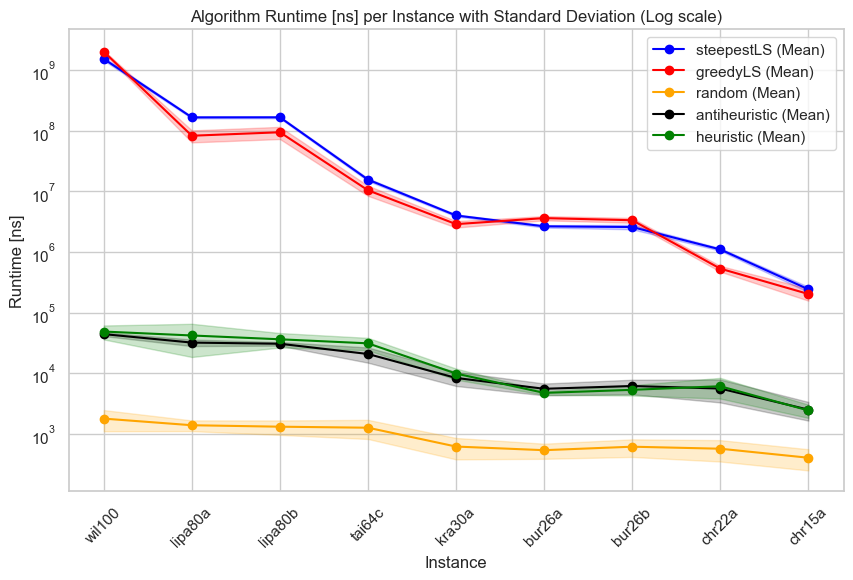

In [ ]:
summary = df_runtime.groupby(["Algorithm", "Instance"])["Runtime"].agg(["mean", "std"]).reset_index()
summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")
plot_algorithms(summary, title="Runtime [ns]", log_scale=True)

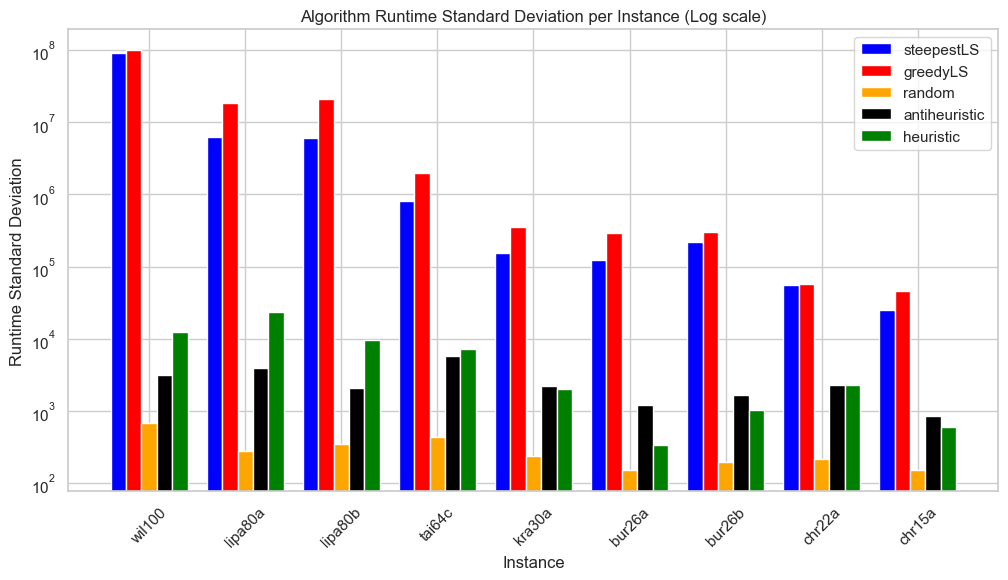

In [ ]:
plot_std_bar(summary, title="Runtime Standard Deviation", log_scale=True)

In [ ]:
# ls_algorithms = summary[summary["Algorithm"].str.contains("LS")]
# plot_algorithms(ls_algorithms, title="Runtime [ns]")

In [ ]:
# non_ls_algorithms = summary[~summary["Algorithm"].str.contains("LS")]
# plot_algorithms(non_ls_algorithms, title="Runtime [ns]")

## Quality

In [ ]:
df_performance["Solution_Quality"] = (df_performance["Score"] - df_performance["Optimal_Score"]) / df_performance["Optimal_Score"] * 100

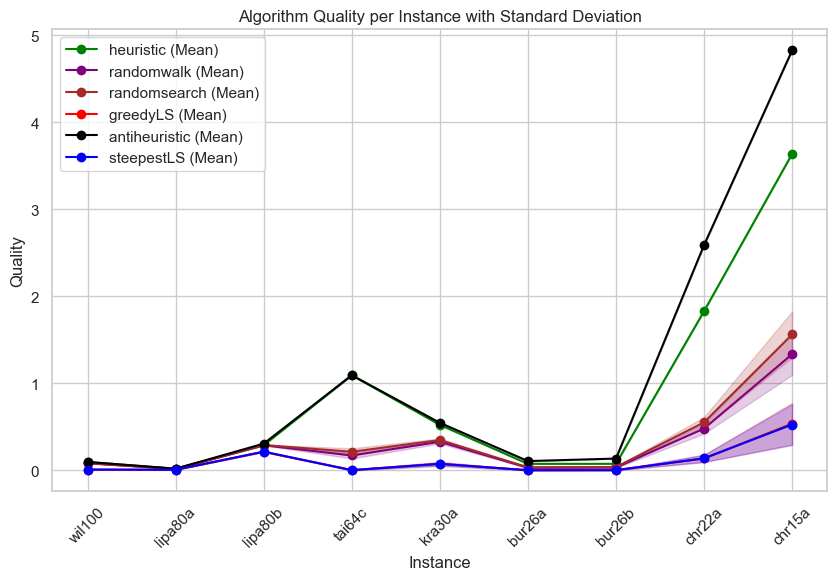

In [ ]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Solution_Quality"].agg(["mean", "std"]).reset_index()
summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")
plot_algorithms(summary, title="Quality", log_scale=False)

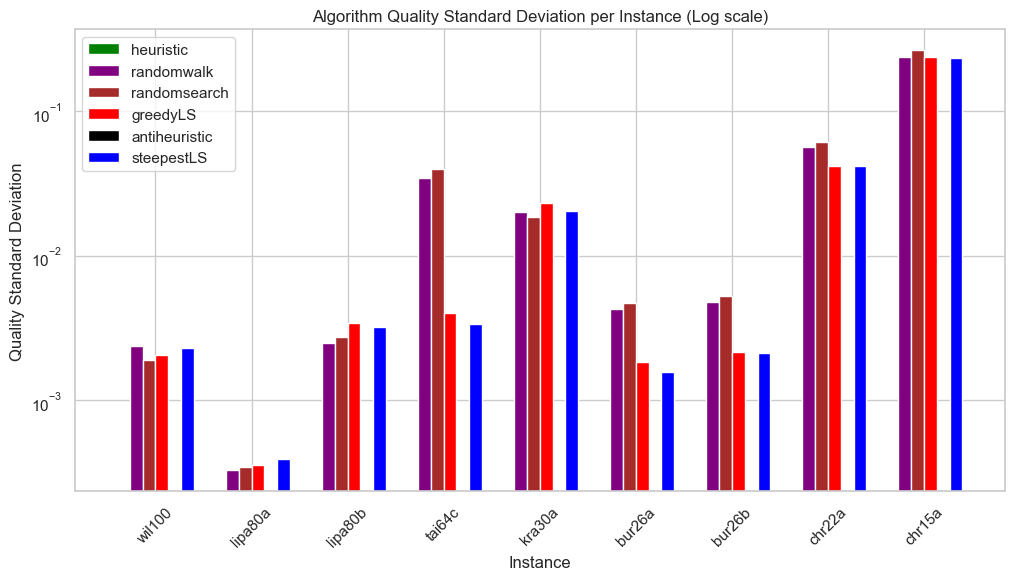

In [ ]:
plot_std_bar(summary, title="Quality Standard Deviation", log_scale=True)

In [ ]:
# non_ls_algorithms = summary[~summary["Instance"].str.contains("chr|tai|kra|lipa80b")]
# plot_algorithms(non_ls_algorithms, title="Quality")

## Efficiency

In [ ]:
df_runtime_summary = df_runtime.groupby(["Algorithm", "Instance"]).agg(
    mean_runtime=("Runtime", "mean"),
    std_runtime=("Runtime", "std")
).reset_index()

df_combined = df_performance.merge(df_runtime_summary, on=["Algorithm", "Instance"], how="left")

df_combined["Solution_Quality"] = (df_combined["Score"] - df_combined["Optimal_Score"]) / df_combined["Optimal_Score"] * 100

df_combined.loc[df_combined["Algorithm"].isin(["randomwalk", "randomsearch"]), "mean_runtime"] = RANDOMRUNTIME
df_combined.loc[df_combined["Algorithm"].isin(["randomwalk", "randomsearch"]), "std_runtime"] = 0.0

df_combined.head()

,Algorithm,Instance,Initial_Score,Score,Number_of_Evaluations,Number_of_Performed_Moves,Number_of_Best_Solution_Updates,Solution,Optimal_Score,Optimal_Solution,Solution_Quality,mean_runtime,std_runtime
0,heuristic,wil100,0,299894,1,1,1,1 73 22 17 43 39 5 82 97 29 76 57 35 96 99 94 ...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,0.09836,48555.2,12593.455547
1,heuristic,wil100,0,299894,1,1,1,1 73 22 17 43 39 5 82 97 29 76 57 35 96 99 94 ...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,0.09836,48555.2,12593.455547
2,heuristic,wil100,0,299894,1,1,1,1 73 22 17 43 39 5 82 97 29 76 57 35 96 99 94 ...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,0.09836,48555.2,12593.455547
3,heuristic,wil100,0,299894,1,1,1,1 73 22 17 43 39 5 82 97 29 76 57 35 96 99 94 ...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,0.09836,48555.2,12593.455547
4,heuristic,wil100,0,299894,1,1,1,1 73 22 17 43 39 5 82 97 29 76 57 35 96 99 94 ...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,0.09836,48555.2,12593.455547


In [ ]:
def plot_efficiency(summary, legend=True, show_instances=True, 
                    title="Algorithm Performance: Runtime vs. Solution Quality",
                    log_scale_x=True, log_scale_y=True):
    # Set up plot
    plt.figure(figsize=(15, 6))
    sns.set_theme(style="whitegrid")

    # Get unique algorithms and instances
    algorithms = summary["Algorithm"].unique()
    instances = summary["Instance"].unique()
    colors = sns.color_palette("tab10", len(algorithms))
    markers = ["o", "s", "D", "v", "^"]  # Different markers for instances
    
    # Dictionary to track if an algorithm has been added to the legend
    algorithm_legend = {}

    # Plot each algorithm-instance pair
    for i, algorithm in enumerate(algorithms):
        for j, instance in enumerate(instances):
            subset = summary[(summary["Algorithm"] == algorithm) & (summary["Instance"] == instance)]
            if not subset.empty:
                if show_instances:
                    label = label=f"{algorithm} - {instance}"
                else:
                    label = algorithm if algorithm not in algorithm_legend else "_nolegend_"
                plt.errorbar(
                    subset["mean_quality"], subset["mean_runtime"],
                    xerr=subset["std_quality"], yerr=subset["std_runtime"],
                    fmt=markers[j % len(markers)], color=algorithm_colors[algorithm], label=label,
                    capsize=3, linestyle="none"
                )
                algorithm_legend[algorithm] = True

    # Labels and legend
    plt.ylabel("Runtime [ns] (Mean ± Std)")
    plt.xlabel("Solution Quality (Mean ± Std)")
    
    if log_scale_x:
        plt.xscale("log")
    
    if log_scale_y:
        plt.yscale("log")
    
    full_title = f"{title}"
    
    if log_scale_x and log_scale_y:
        full_title += " (Log scale x y)"
    elif log_scale_x:
        full_title += " (Log scale x)"
    elif log_scale_y:
        full_title += " (Log scale y)"

    plt.title(full_title)
    if legend:
        plt.legend(loc="upper right", fontsize=9, ncol=5)
    plt.show()


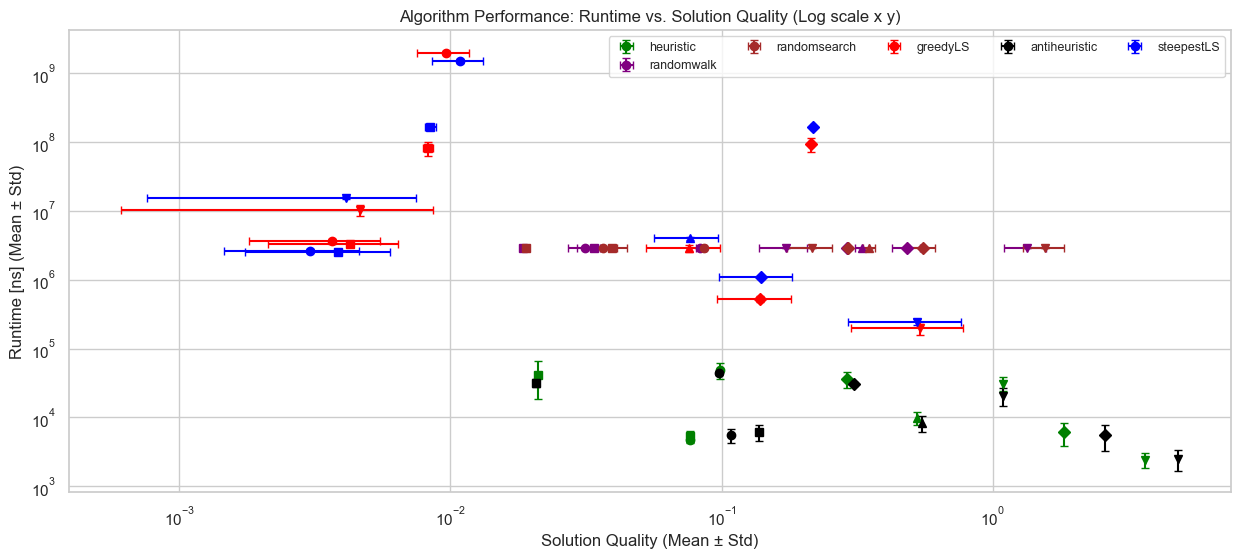

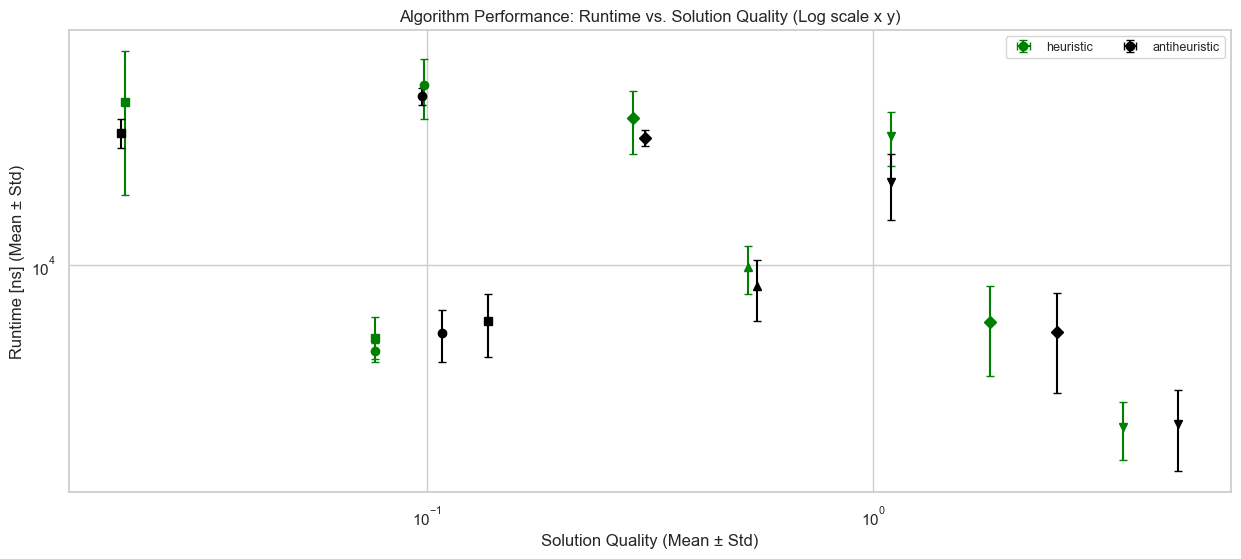

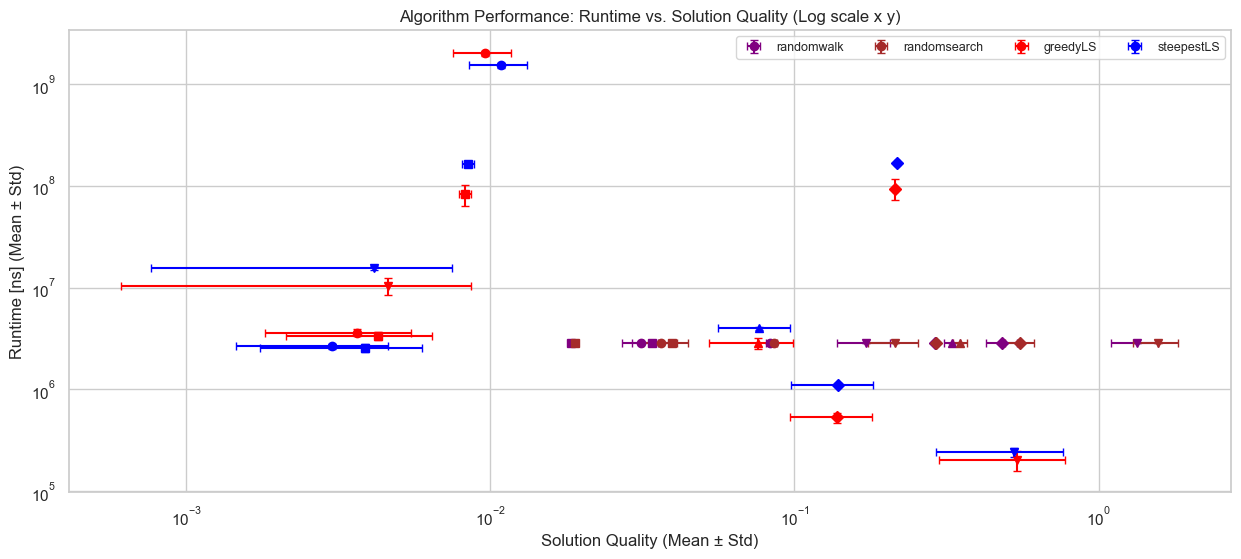

In [ ]:
summary = df_combined.groupby(["Algorithm", "Instance"]).agg(
    mean_runtime=("mean_runtime", "mean"),
    std_runtime=("std_runtime", "mean"),
    mean_quality=("Solution_Quality", "mean"),
    std_quality=("Solution_Quality", "std")
).reset_index()

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

non_ls_algorithms = summary[~summary["Algorithm"].str.contains("LS|random")]
ls_algorithms = summary[summary["Algorithm"].str.contains("LS|random")]

plot_efficiency(summary, show_instances=False, log_scale_x=True, log_scale_y=True)
plot_efficiency(non_ls_algorithms, show_instances=False, log_scale_x=True, log_scale_y=True)
plot_efficiency(ls_algorithms, show_instances=False, log_scale_x=True, log_scale_y=True)

## Number of Moves/Evaluations/Best Solution Updates

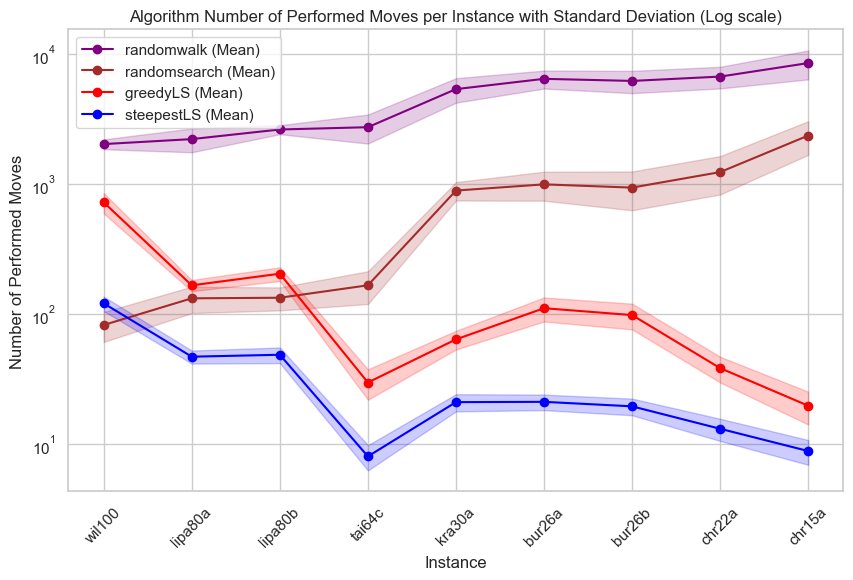

In [ ]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Number_of_Performed_Moves"].agg(["mean", "std"]).reset_index()

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

summary = summary[~summary["Algorithm"].str.contains("heuristic")]
plot_algorithms(summary, title="Number of Performed Moves", log_scale=True)

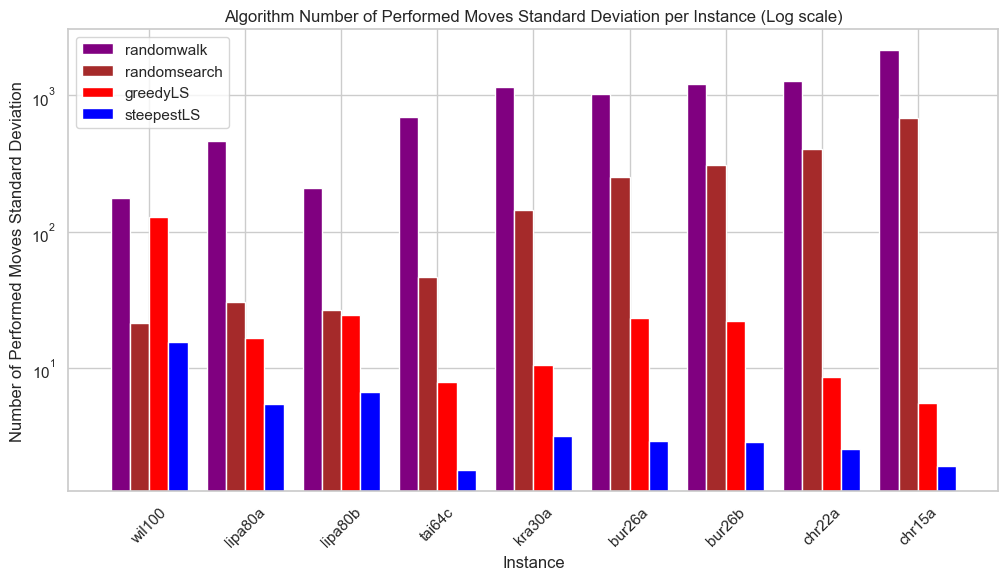

In [ ]:
plot_std_bar(summary, title="Number of Performed Moves Standard Deviation", log_scale=True)

In [ ]:
# ls_algorithms = summary[summary["Algorithm"].str.contains("LS")]
# plot_algorithms(ls_algorithms, title="Number of Performed Moves")

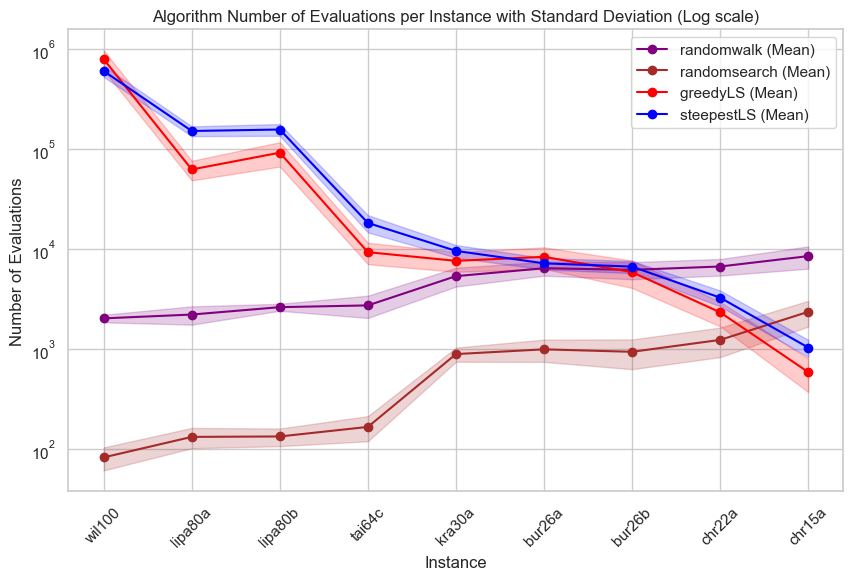

In [ ]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Number_of_Evaluations"].agg(["mean", "std"]).reset_index()

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

summary = summary[~summary["Algorithm"].str.contains("heuristic")]
plot_algorithms(summary, title="Number of Evaluations", log_scale=True)

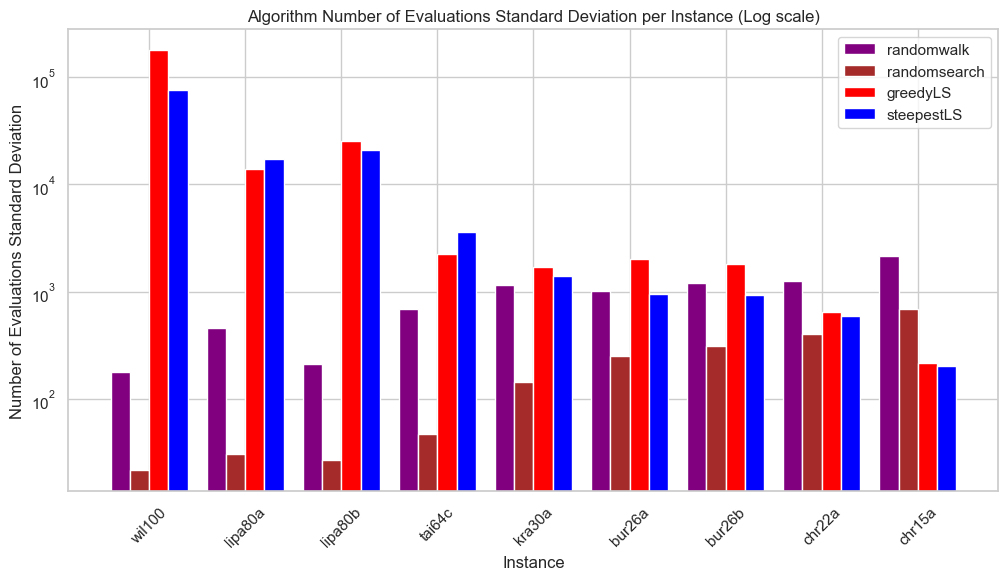

In [ ]:
plot_std_bar(summary, title="Number of Evaluations Standard Deviation", log_scale=True)

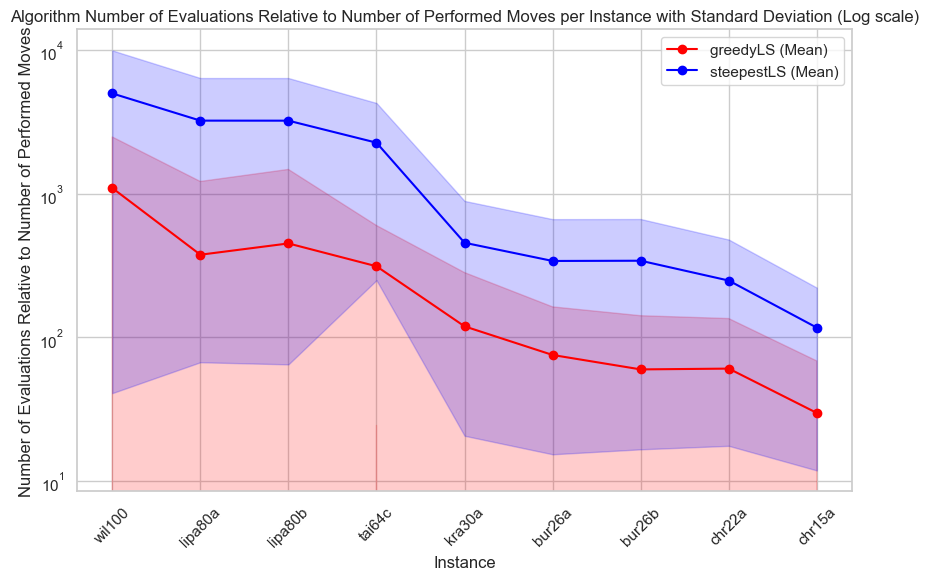

In [ ]:
summary = df_performance.groupby(["Algorithm", "Instance"])[["Number_of_Evaluations", "Number_of_Performed_Moves"]].agg(["mean", "std"]).reset_index()
summary.columns = ['_'.join(col).strip('_') for col in summary.columns]

summary["Relative_Evaluations_mean"] = summary["Number_of_Evaluations_mean"] / summary["Number_of_Performed_Moves_mean"]
summary["Relative_Evaluations_std"] = summary["Number_of_Evaluations_std"] / summary["Number_of_Performed_Moves_std"]

summary = summary[["Algorithm", "Instance", "Relative_Evaluations_mean", "Relative_Evaluations_std"]]
summary = summary.rename(columns={"Relative_Evaluations_mean": "mean", "Relative_Evaluations_std": "std"})

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

summary = summary[summary["Algorithm"].str.contains("LS")]

# TODO weird std?
plot_algorithms(summary, "Number of Evaluations Relative to Number of Performed Moves", log_scale=True)

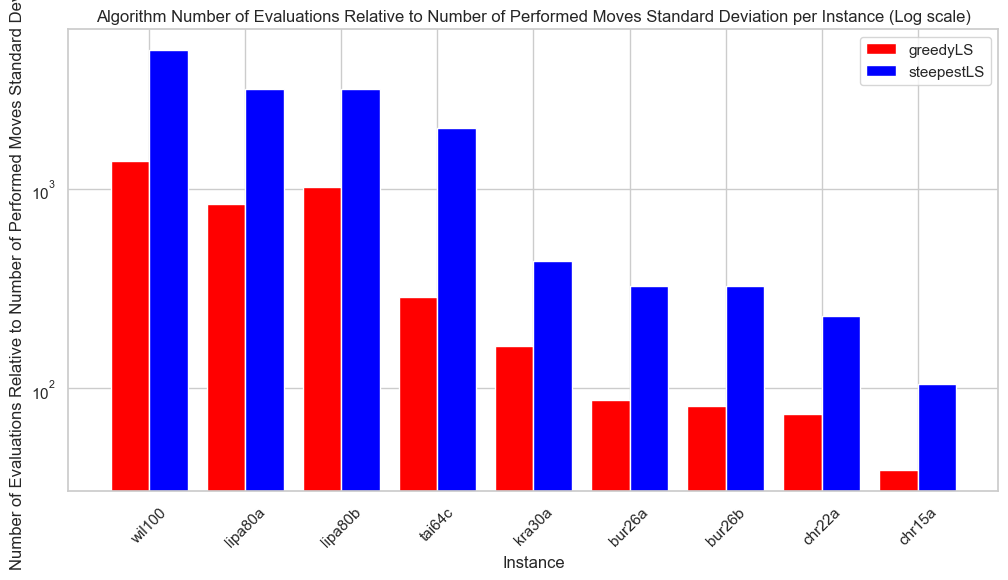

In [ ]:
plot_std_bar(summary, title="Number of Evaluations Relative to Number of Performed Moves Standard Deviation", log_scale=True)

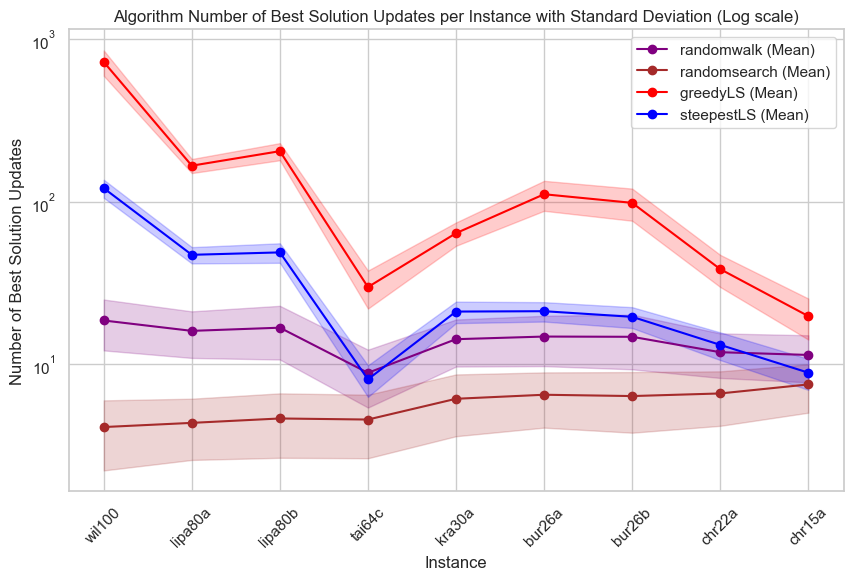

In [ ]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Number_of_Best_Solution_Updates"].agg(["mean", "std"]).reset_index()

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

summary = summary[~summary["Algorithm"].str.contains("heuristic")]
plot_algorithms(summary, title="Number of Best Solution Updates", log_scale=True)

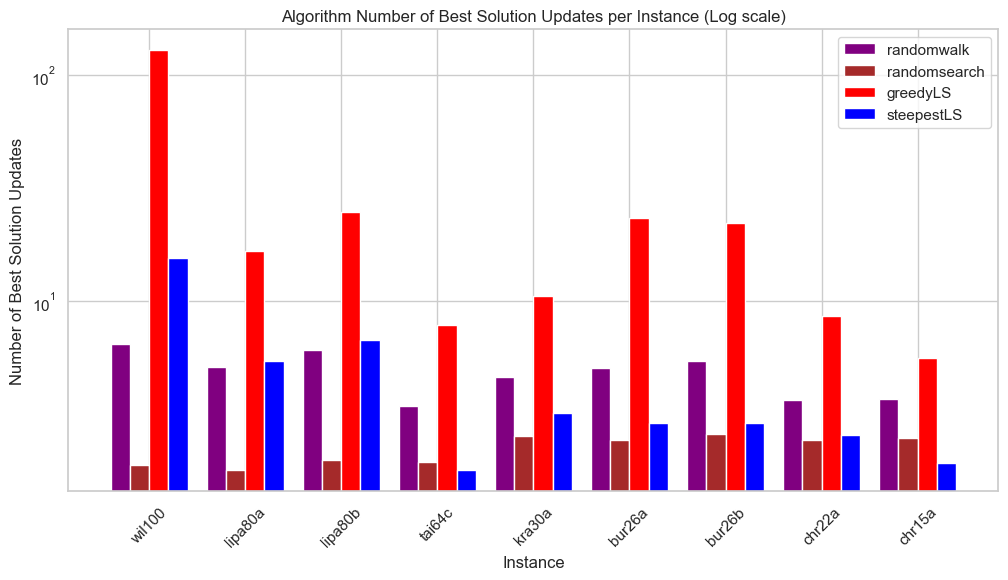

In [ ]:
plot_std_bar(summary, title="Number of Best Solution Updates", log_scale=True)

## Initial Solution Comparison

TODO: use performance data from 200 repetitions

In [ ]:
def plot_ls_algorithms_comparison(df, algorithm=""):
    # Set up plot
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")

    # Scatter plot with different colors per algorithm
    sns.scatterplot(
        data=df,
        x="Initial_Score",
        y="Score",
        hue="Instance",
        palette="tab10",
        alpha=0.6  # Slight transparency for better visibility
    )

    # Labels and title
    plt.yscale("log") 
    plt.xscale("log") 

    # plt.xlabel("Initial Solution Score")
    # plt.ylabel("Final Solution Score")
    plt.title(f"Comparison of LS Algorithms: Initial vs. Final Solution Score {algorithm}")
    plt.legend(title="Instance", loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside

    # Show plot
    plt.show()

def plot_ls_algorithms_comparison_all(df, algorithm=""):
    # Set up plot
    sns.set_theme(style="whitegrid")
    
    g = sns.FacetGrid(
        df, col="Instance", hue="Instance", palette="tab10", col_wrap=3, sharex=False, sharey=False
    )
    g.map_dataframe(sns.scatterplot, x="Initial_Score", y="Score")
    
    # Compute correlation and set subplot titles
    def set_titles(**kwargs):
        ax = plt.gca()
        instance = kwargs.get('label', '')
        subset = df[df['Instance'] == instance]
        correlation = subset["Initial_Score"].corr(subset["Score"]) if not subset.empty else np.nan
        ax.set_title(f"{instance} Cor = {correlation:.2f}")
    
    g.map_dataframe(set_titles)
    
    g.figure.suptitle(f"Comparison of LS Algorithms: Initial vs. Final Solution Score {algorithm}", fontsize=16)
    g.figure.subplots_adjust(top=0.9)
    
    plt.show()

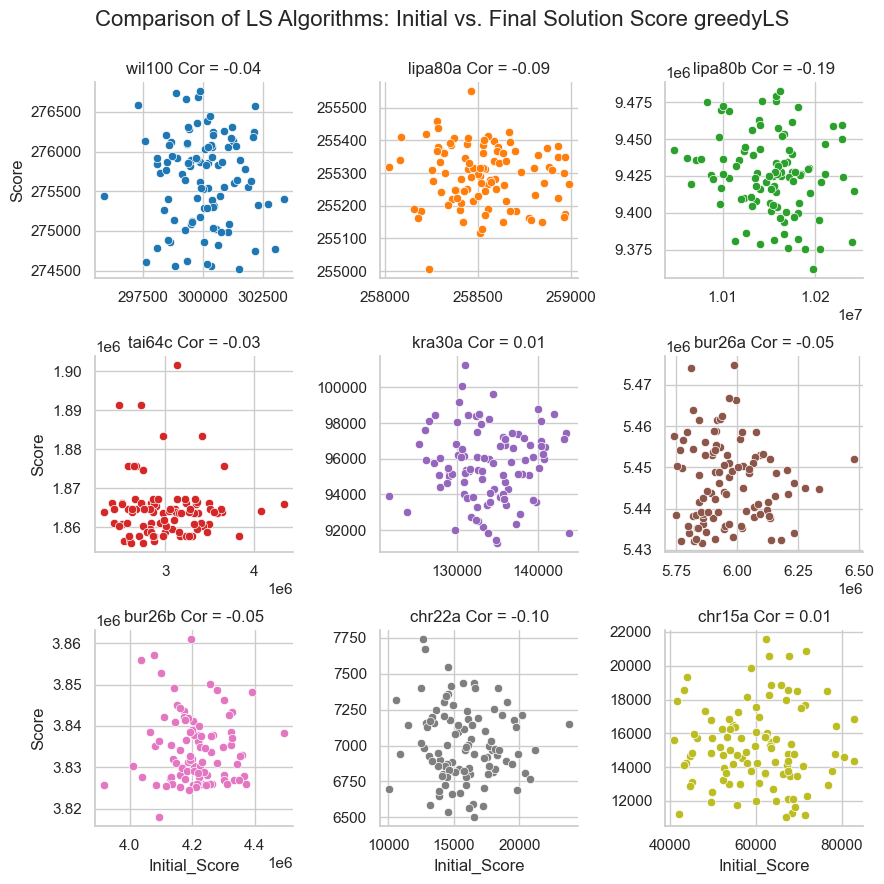

In [ ]:
plot_ls_algorithms_comparison_all(df_performance[df_performance["Algorithm"].str.contains("greedyLS", case=False, na=False)], algorithm="greedyLS")

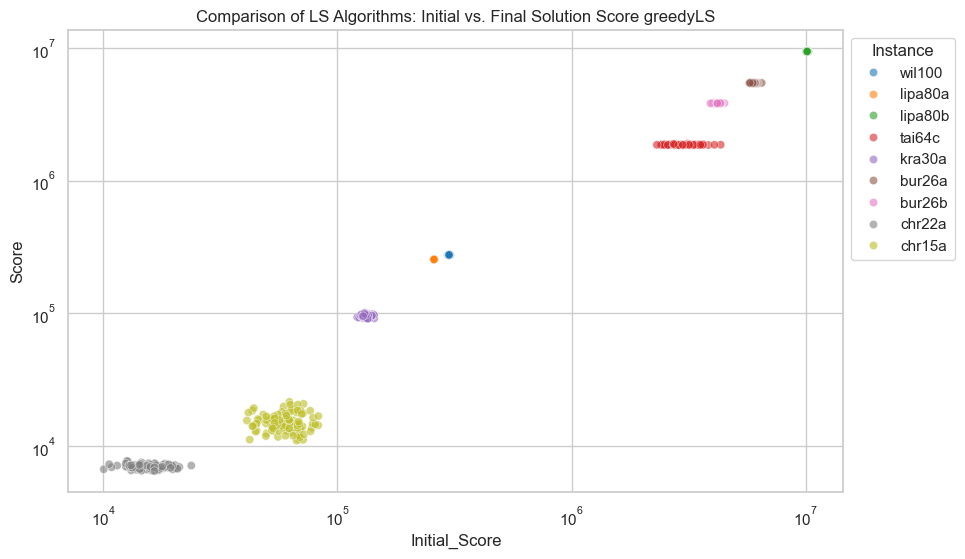

In [ ]:
# TODO log scale?
plot_ls_algorithms_comparison(df_performance[df_performance["Algorithm"].str.contains("greedyLS", case=False, na=False)], algorithm="greedyLS")

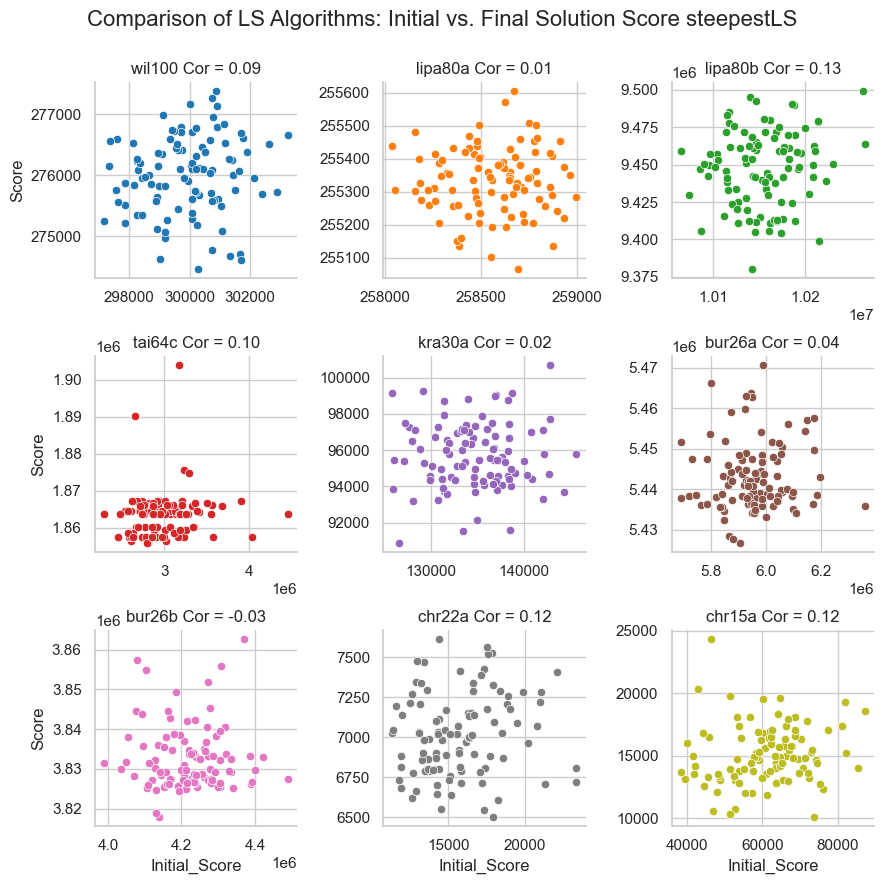

In [ ]:
plot_ls_algorithms_comparison_all(df_performance[df_performance["Algorithm"].str.contains("steepestLS", case=False, na=False)], algorithm="steepestLS")

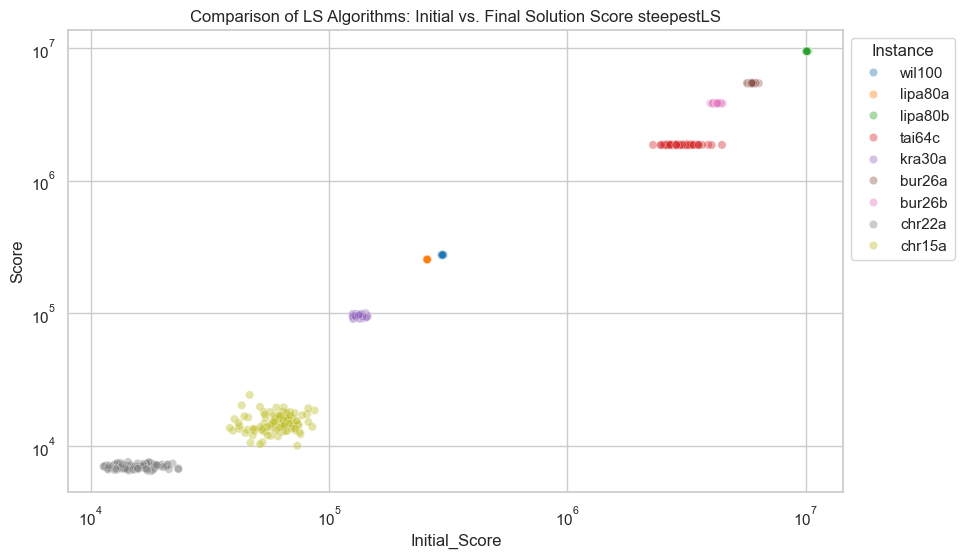

In [ ]:
plot_ls_algorithms_comparison(df_performance[df_performance["Algorithm"].str.contains("steepestLS", case=False, na=False)], "steepestLS")

## Number of Restarts Influence

Done for:
- chr22a - due to high variability of final and initial quality
- tai64c - large spraed of initial values scores


TODO: musimy zmienic tai bo sa za latwe 

In [ ]:
num_restarts = [20, 50, 100, 150, 200, 300, 500]
performance_files_path = "results/MSLS_tests/"
selected_instances = ["chr22a", "tai64c"]

dfs_msls = []
for n_restarts in num_restarts:
    performance_file = performance_files_path + f"{n_restarts}_restarts_performance.txt"
    with open(performance_file, 'r') as file:
        data = file.read()

    df_perf = parse_performance_data(data)
    df_perf.Algorithm = df_perf.Algorithm.apply(lambda x: x[1:] if x.endswith("LS") else x)
    df_perf = df_perf[["Algorithm", "Instance", "Initial_Score", "Score", "Solution"]]
    dfs_msls.append((n_restarts, df_perf))

In [ ]:
def plot_algorithm_performance(restart_data):
    sns.set_theme(style="whitegrid")
    
    # Create a combined dataframe
    avg_results = []
    best_results = []
    for num_restarts, df in restart_data:
        df["Restarts"] = num_restarts  # Ensure Restarts column is correctly assigned
        avg_scores = df.groupby(["Instance", "Algorithm", "Restarts"], as_index=False)["Score"].mean()
        best_scores = df.groupby(["Instance", "Algorithm", "Restarts"], as_index=False)["Score"].min()
        avg_results.append(avg_scores)
        best_results.append(best_scores)
    
    avg_df = pd.concat(avg_results, ignore_index=True).sort_values(["Instance", "Algorithm", "Restarts"])
    best_df = pd.concat(best_results, ignore_index=True).sort_values(["Instance", "Algorithm", "Restarts"])
    
    instances = avg_df["Instance"].unique()
    
    for instance in instances:
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=avg_df[avg_df["Instance"] == instance], x="Restarts", y="Score", hue="Algorithm", palette=algorithm_colors, marker="o")
        plt.title(f"Average Solution Score vs. Number of Restarts ({instance})")
        plt.xlabel("Number of Restarts")
        plt.ylabel("Average Score")
        plt.legend(title="Algorithm")
        plt.show()
        
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=best_df[best_df["Instance"] == instance], x="Restarts", y="Score", hue="Algorithm", palette=algorithm_colors, marker="o")
        plt.title(f"Best Solution Score vs. Number of Restarts ({instance})")
        plt.xlabel("Number of Restarts")
        plt.ylabel("Best Score")
        plt.legend(title="Algorithm")
        plt.show()


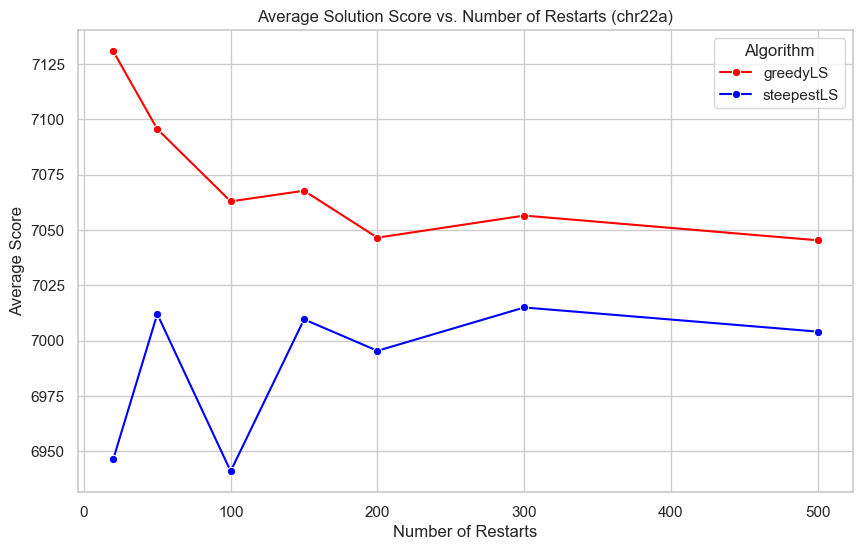

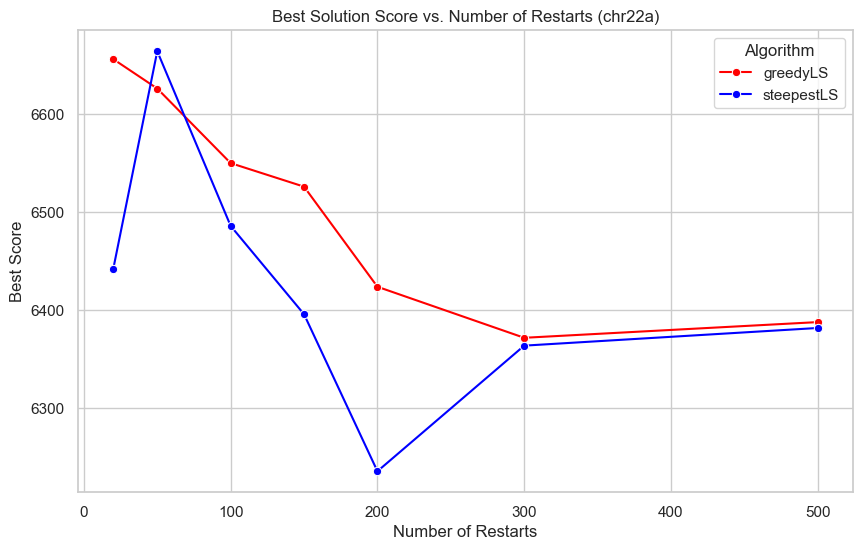

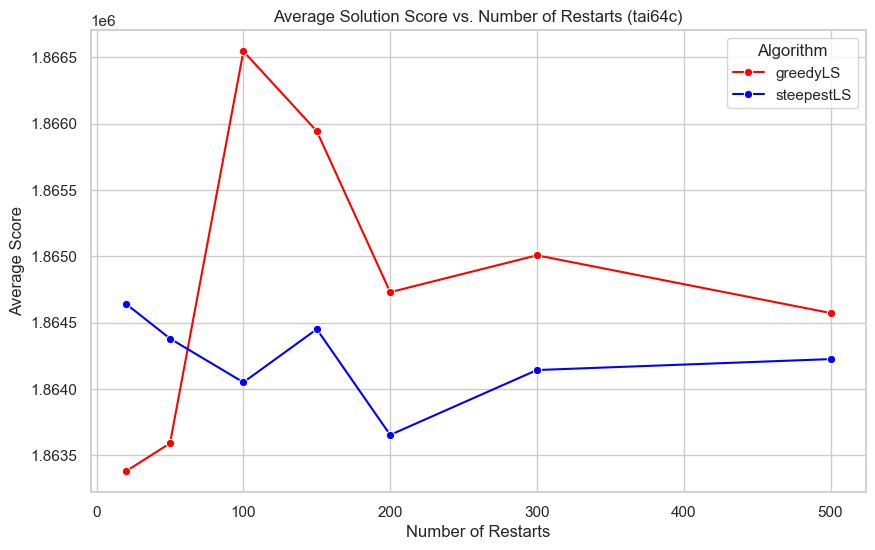

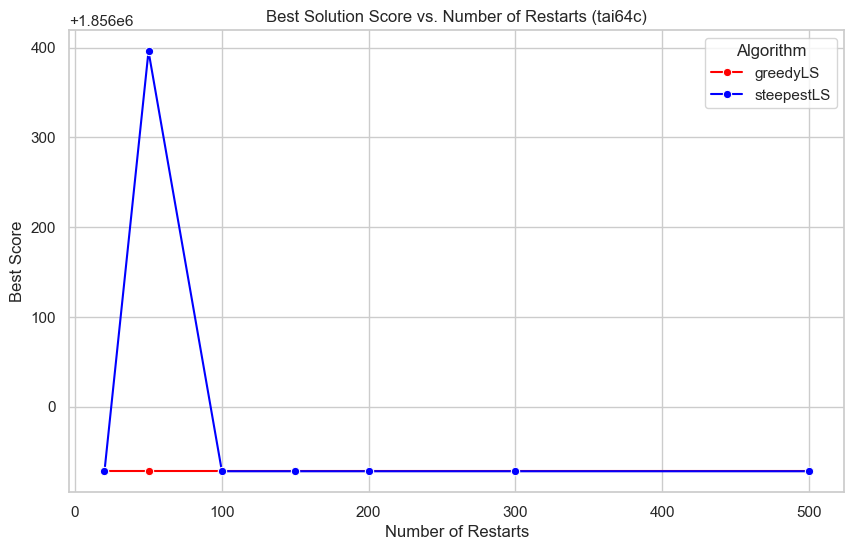

In [ ]:
plot_algorithm_performance(dfs_msls)

## Similarity of Locally Optimal Solutions

In [ ]:
performance_file = performance_files_path + f"300_restarts_performance.txt"
with open(performance_file, 'r') as file:
    data = file.read()

df_perf_300 = parse_performance_data(data)
df_perf_300.Algorithm = df_perf_300.Algorithm.apply(lambda x: x[1:] if x.endswith("LS") else x)

df_perf_300.Solution = df_perf_300.Solution.apply(lambda x: list(map(int, x.split(" ")[:-1])))
df_perf_300.Optimal_Solution = df_perf_300.Optimal_Solution.apply(lambda x: list(map(int, x.split(" ")[:-1])))
df_perf_300.tail()

,Algorithm,Instance,Initial_Score,Score,Number_of_Evaluations,Number_of_Performed_Moves,Number_of_Best_Solution_Updates,Solution,Optimal_Score,Optimal_Solution
1195,steepestLS,chr22a,13840,6986,4389,18,18,"[9, 3, 20, 17, 18, 11, 2, 19, 13, 5, 4, 8, 12,...",6156,"[15, 2, 21, 8, 16, 1, 7, 18, 14, 13, 5, 17, 6,..."
1196,steepestLS,chr22a,13722,6508,4389,18,18,"[2, 12, 6, 16, 9, 3, 15, 20, 10, 5, 17, 19, 11...",6156,"[15, 2, 21, 8, 16, 1, 7, 18, 14, 13, 5, 17, 6,..."
1197,steepestLS,chr22a,10560,7170,2541,10,10,"[18, 4, 0, 8, 9, 15, 16, 21, 5, 20, 17, 6, 3, ...",6156,"[15, 2, 21, 8, 16, 1, 7, 18, 14, 13, 5, 17, 6,..."
1198,steepestLS,chr22a,15828,7228,4158,17,17,"[14, 4, 1, 7, 20, 15, 13, 16, 0, 9, 12, 6, 3, ...",6156,"[15, 2, 21, 8, 16, 1, 7, 18, 14, 13, 5, 17, 6,..."
1199,steepestLS,chr22a,16616,6364,4620,19,19,"[5, 1, 7, 12, 9, 0, 6, 21, 14, 2, 20, 18, 16, ...",6156,"[15, 2, 21, 8, 16, 1, 7, 18, 14, 13, 5, 17, 6,..."


In [ ]:
def compute_similarity(solution1, solution2):
    return sum(1 for a, b in zip(solution1, solution2) if a == b)/len(solution1)*100

def plot_solution_quality_vs_similarity(df, instances=["chr15a", "tai64c"]):
    sns.set_theme(style="whitegrid")
    
    for instance in instances:
        subset = df[df["Instance"] == instance]
        
        plot_data = []
        
        # print(subset)
        for _, row in subset.iterrows():
            similarity = compute_similarity(row["Optimal_Solution"], row["Solution"])
            plot_data.append({
                "Algorithm": row["Algorithm"],
                "Quality": (row["Score"] - row["Optimal_Score"]) / row["Optimal_Score"] * 100,
                "Similarity": similarity
            })
        
        plot_df = pd.DataFrame(plot_data)
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=plot_df, x="Quality", y="Similarity", hue="Algorithm", palette=algorithm_colors, alpha=0.7)
        plt.title(f"Solution Quality vs. Similarity to Optimal Solution for {instance}")
        plt.xlabel("Solution Quality")
        plt.ylabel("Similarity to Optimal Solution (%)")
        plt.legend(title="Algorithm")
        plt.show()


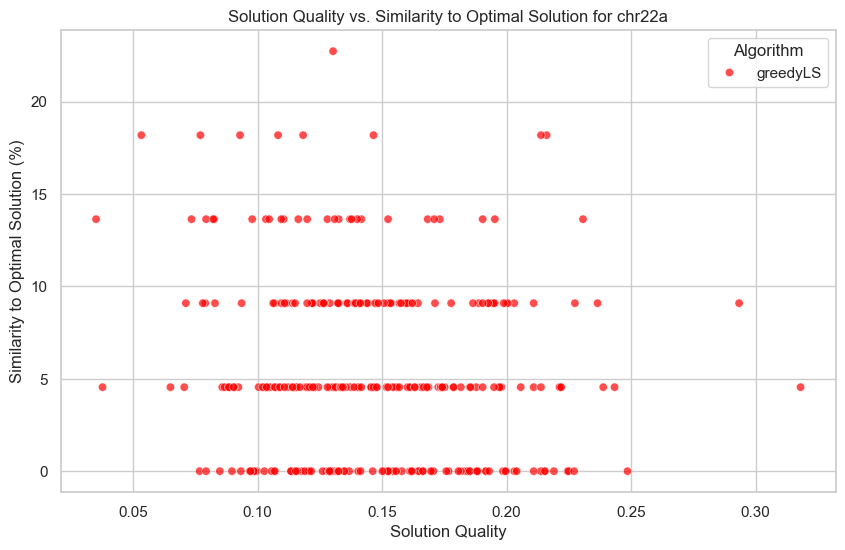

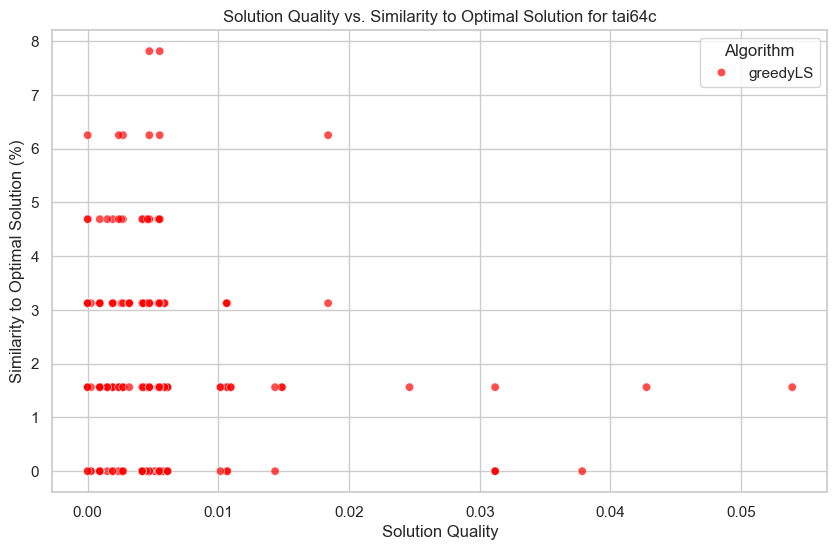

In [ ]:
plot_solution_quality_vs_similarity(df_perf_300[df_perf_300.Algorithm == "greedyLS"], selected_instances)

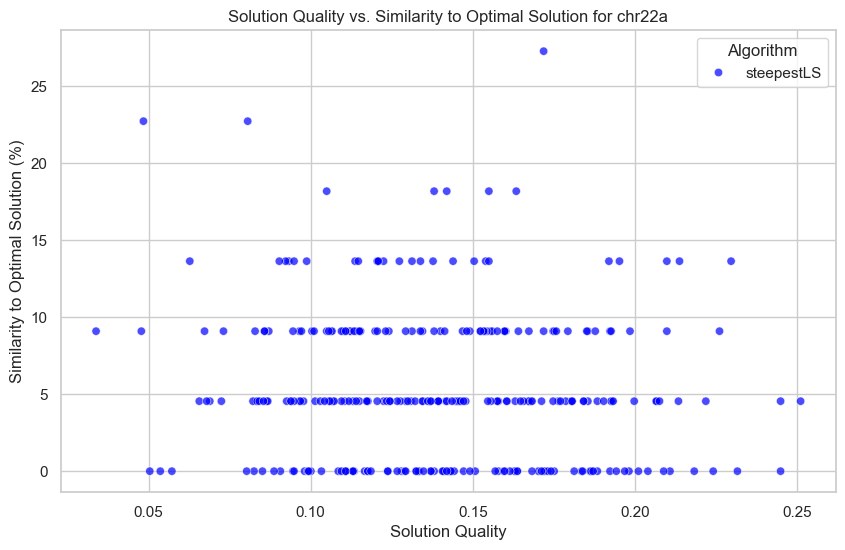

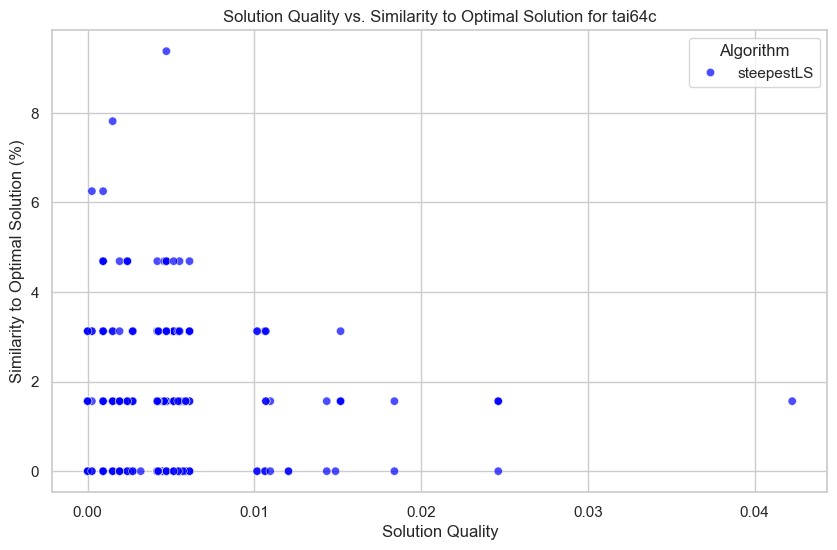

In [ ]:
plot_solution_quality_vs_similarity(df_perf_300[df_perf_300.Algorithm == "steepestLS"], selected_instances)